# Import functions

In [85]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed
np.random.seed(1)
torch.manual_seed(1)

# HJ PDE Experiment: 1D Quadratic term with initial data J(x) = -|x|

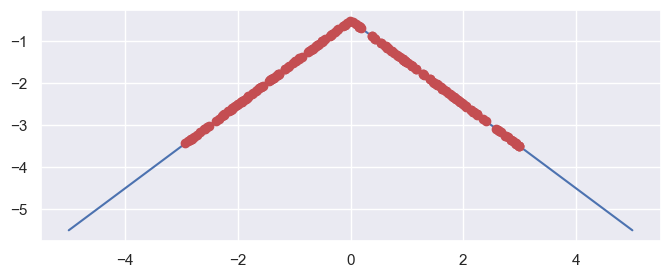

In [86]:
# We consider here the non-convex optimization problem:
# S(y) = min_{x \in \R} \frac{1}{2}(x-y)^{2} - |x|,

# This problem admits the explicit solution
# S(y) = -|y| - 1/2.

# We'll train a Learned Proximal Network to learn the solution
# of this problem from a set of K samples (yk,S(yk))_{k=1}^{K}.

# Function for sampling (yk,S(yk,t))_{k=1}^{K} at a fixed t in one dimension.
def sample_sol_negative_abs(K,mean,stdev):
    """
    Inputs:
        K:  number of samples to generate
        t:  hyperparameter t in the problem
    Outputs:
        y:  a K x 1 matrix of points sampled randomly
            according to a uniform random Gaussian variable
        Sy: a K x 1 vector of points corresponding to the 
            solution S(y,t).
    """
    
    # Generate samples yk and the target function S(yk)
    # Sample uniformly in [-3,3]

    y = -3 + 6*torch.rand(size=(K,1))     #y = torch.normal(mean, stdev, size=(K,1)) 
    Sy = -torch.abs(y) - 0.5
    return y, Sy

def compute_true_solution(y):
    Sytrue = -torch.abs(y) - 0.5
    return Sytrue

# Generate samples
K = 200      # Number of pairs (xk,S(yk,t))
ysamples, Sysamples = sample_sol_negative_abs(K, 0.0, 1.0)

# Plot the actual solution and the samples
ytrue = np.linspace(-5,5,25)
Sytrue = -np.absolute(ytrue) - 1/2

plt.plot(ytrue,Sytrue,'-');
plt.plot(ysamples.numpy(),Sysamples.numpy(),'o', color='r');

# Model parameters

In [87]:
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# Create a model
lpn_model = LPN(in_dim = 1, hidden=hidden, layers=layers, beta=beta).to(device)

print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


# Plot function

In [88]:
# Plotting an LPN model
# function to plot learned prox, convex function, original function
def plot_all(model,ysamples,Sysamples):
    xi = np.linspace(-3, 3, 200)

    prox_y = prox(xi, model)
    c = cvx(xi, model)

    ysamples = ysamples.detach().numpy()
    Sysamples = Sysamples.detach().numpy()

    plt.rcParams["figure.figsize"] = (8, 3)

    # Learned proximal operator
    # TODO: plot the real proximal term
    plt.subplot(1, 4, 1)
    plt.plot(xi, prox_y, "o", ms=5, label="LPN")
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # Convex function (0.5*y^2 - S(y,t))
    # cvx(y) = 0.5*y^2 +|y| + 1/2.
    plt.subplot(1, 4, 2)
    plt.plot(xi, c - c.min(), "--", ms=5, label="Cvx func")
    plt.plot(xi, 0.5*pow(xi,2) - (-abs(xi)-0.5), "o", label="ref.")
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # True initial data J(y)
    plt.subplot(1, 4, 3)
    plt.plot(xi, -np.abs(xi), "--", label=r"$-\ell_1$", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Initial data")

    # Solution to HJ PDE S(y,t)

    plt.tight_layout()

# Proximal matching loss

In [89]:
# Proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

# Training function

In [90]:
# Defines what is a single iteration in the training of the LPN.

def single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss=None):
    input = ysamples
    out = lpn_model(input)
    target = 0.5*(torch.pow(ysamples,2)) - Sysamples
    fout = 0.5*(torch.pow(ysamples,2)) - compute_true_solution(out)

    if loss_type == 2:
        loss = (fout - target).pow(2).sum() / (K*(target).pow(2).sum())  # MSE loss
    elif loss_type == 1:
        loss = (fout - target).abs().sum() / (K*(target).abs().sum())  # MAE loss
    elif loss_type == 0:
        loss = exp_func(fout - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor

    if not i % 500:
        print("iteration", i, "loss", loss.item())

# Train

L2 loss

iteration 0 loss 0.0003323274140711874
iteration 500 loss 7.645982987014577e-05
iteration 1000 loss 1.9737919501494616e-05
iteration 1500 loss 4.897628059552517e-06
iteration 2000 loss 1.1270507229710347e-06
iteration 2500 loss 4.6758032112848014e-07
iteration 3000 loss 2.4015341182348493e-07
iteration 3500 loss 1.3700218914891593e-07
iteration 4000 loss 8.038794163667262e-08
iteration 4500 loss 4.811960252482095e-08
iteration 5000 loss 2.975298230012413e-08
iteration 5500 loss 1.9114134275355354e-08
iteration 6000 loss 1.2714752806175511e-08
iteration 6500 loss 8.685596242230531e-09
iteration 7000 loss 6.117812922923349e-09
iteration 7500 loss 4.478727166912222e-09
iteration 8000 loss 3.352256916500096e-09
iteration 8500 loss 2.5230044720103706e-09
iteration 9000 loss 1.8942494239837515e-09
iteration 9500 loss 1.4234098344445556e-09
iteration 10000 loss 1.0687460916258829e-09
iteration 10500 loss 8.145343843857233e-10
iteration 11000 loss 6.245904904389477e-10
iteration 11500 loss 4.8

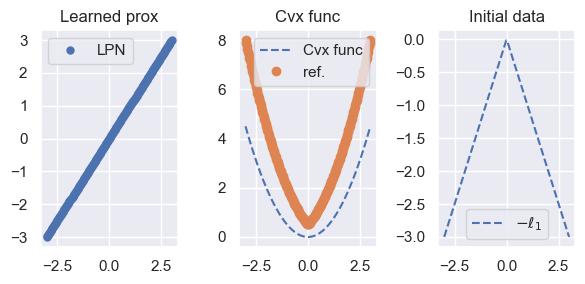

In [91]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-4)
loss_type = 2


# Train for 10000 iterations
for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model,ysamples,Sysamples)
# print(
#     "Values at [-3,-2,-1,0,1,2,3]:",
#     lpn_model(
#         torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
#     ).squeeze(1),
# )


L1 loss

iteration 0 loss 0.0018383224960416555
iteration 500 loss 2.794894862745423e-05
iteration 1000 loss 1.778549631126225e-05
iteration 1500 loss 5.660622991854325e-05
iteration 2000 loss 2.7842772396979854e-05
iteration 2500 loss 1.9000326574314386e-05
iteration 3000 loss 2.0020741430926137e-05
iteration 3500 loss 3.320500036352314e-05
iteration 4000 loss 1.156974394689314e-05
iteration 4500 loss 2.0367520846775733e-05
iteration 5000 loss 2.2125810573925264e-05
iteration 5500 loss 1.826200241339393e-05
iteration 6000 loss 1.6379748558392748e-05
iteration 6500 loss 1.2168399734946433e-05
iteration 7000 loss 1.72795080288779e-05
iteration 7500 loss 3.182749424013309e-05
iteration 8000 loss 1.5889378119027242e-05
iteration 8500 loss 2.974918061227072e-05
iteration 9000 loss 2.2285716113401577e-05
iteration 9500 loss 2.161262818844989e-05
iteration 10000 loss 9.22401886782609e-06
iteration 10500 loss 1.5525905837421305e-05
iteration 11000 loss 1.7366688553011045e-05
iteration 11500 loss 2.346

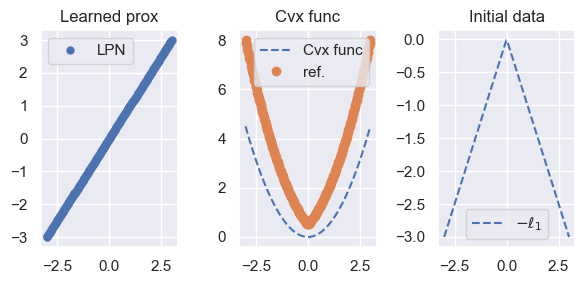

In [92]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
loss_type = 1

# Train for 10000 iterations
for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model,ysamples,Sysamples)

Proximal matching loss with gamma = 0.1

iteration 0 loss 8.493661880493164e-07
iteration 500 loss 6.467104185503558e-07
iteration 1000 loss 6.359815643008915e-07
iteration 1500 loss 6.237626166694099e-07
iteration 2000 loss 6.127357323748583e-07
iteration 2500 loss 5.978345711810107e-07
iteration 3000 loss 5.823374067404075e-07
iteration 3500 loss 5.668401854563854e-07
iteration 0 loss 5.441904136205267e-07
iteration 500 loss 5.429982934401778e-07
iteration 1000 loss 5.412101700130734e-07
iteration 1500 loss 5.397200766310561e-07
iteration 2000 loss 5.367398330236028e-07
iteration 2500 loss 5.328654992808879e-07
iteration 3000 loss 5.295872824717662e-07
iteration 3500 loss 5.21540641784668e-07
iteration 4000 loss 5.117058776704653e-07
iteration 4500 loss 4.997849600840709e-07
iteration 5000 loss 4.994869300389837e-07
iteration 5500 loss 4.729628528821195e-07
iteration 6000 loss 4.6193599700927734e-07
iteration 6500 loss 4.515051728049002e-07
iteration 7000 loss 4.3898819512833143e-07
iteration 7500 loss 4.276633376321115e-07

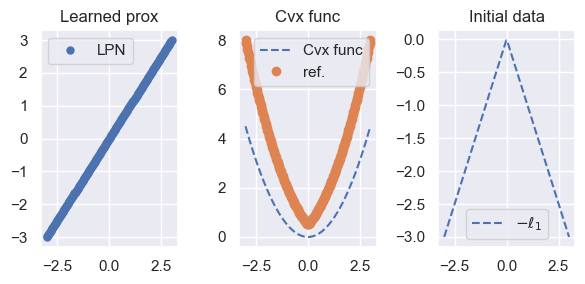

In [93]:
loss_type = 0
gamma_loss = 0.1

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples)

Proximal matching with gamma = 0.01

iteration 0 loss 3.8610698538832366e-05
iteration 500 loss 3.864348036586307e-05
iteration 1000 loss 3.839373675873503e-05
iteration 1500 loss 3.8098394725238904e-05
iteration 2000 loss 3.7756861274829134e-05
iteration 2500 loss 3.732472760020755e-05
iteration 3000 loss 3.677457425510511e-05
iteration 3500 loss 3.614246816141531e-05
iteration 0 loss 3.541201294865459e-05
iteration 500 loss 3.5359858884476125e-05
iteration 1000 loss 3.5288630897412077e-05
iteration 1500 loss 3.520727113937028e-05
iteration 2000 loss 3.505319182295352e-05
iteration 2500 loss 3.490984454401769e-05
iteration 3000 loss 3.467857823125087e-05
iteration 3500 loss 3.4365653846180066e-05
iteration 4000 loss 3.3996402635239065e-05
iteration 4500 loss 3.347516030771658e-05
iteration 5000 loss 3.288507286924869e-05
iteration 5500 loss 3.234952600905672e-05
iteration 6000 loss 3.174722223775461e-05
iteration 6500 loss 3.121793270111084e-05
iteration 7000 loss 3.06740403175354e-05
iteration 7500 loss 3.01852815027814

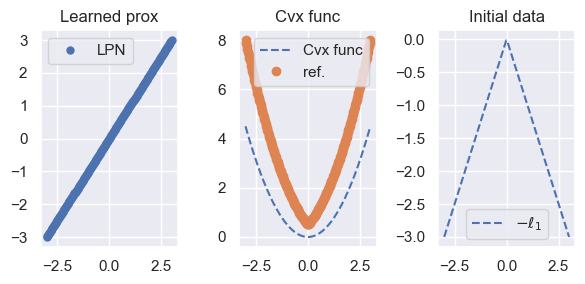

In [94]:
loss_type = 0
gamma_loss = 0.01

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples)

## Some notes:
# There needs to be a continuity assumption on the proximal term for this to work (as it stands).